In [11]:
import warnings

warnings.filterwarnings('ignore')

KNN

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import make_column_selector as selector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 10
# Load data
df = pd.read_csv("GroupProjectDataSet.csv", sep=',')
# Assess missing values
cols = df.columns[df.isna().any()]
df_nan = df[cols].copy()
df_nan['Class'] = df['Class']
df_nan.isna().sum() / df_nan.shape[0]
df = df.dropna(thresh=df.shape[0] * 0.4, axis=1)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X.info()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
import warnings
warnings.filterwarnings('ignore')
num_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), ("imputer", SimpleImputer(strategy="median"))]
)
cat_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectKBest(f_classif, k=10)), # Select the top 10 features
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, selector(dtype_include=np.number)),
        ("cat", cat_transformer, selector(dtype_include=object)),
    ]
)
# KNN Classifier
knn_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier())]
)
# Fit the KNN Classifier
knn_clf.fit(X_train, y_train)
print("KNN model score: %.3f" % knn_clf.score(X_test, y_test))
# Hyperparameter tuning for KNN
knn_param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "preprocessor__cat__selector__k": [5, 10, 15, 20],
    "classifier__n_neighbors": [3, 5, 7, 9],
    "classifier__weights": ["uniform", "distance"],
    "classifier__p": [1, 2],
}
knn_search_cv = RandomizedSearchCV(knn_clf, knn_param_grid, n_iter=10, random_state=0, cv=cv )
knn_search_cv.fit(X_train, y_train)
# Print results for KNN
print('KNN Best CV accuracy: {:.2f}'.format(knn_search_cv.best_score_))
print('KNN Test score:       {:.2f}'.format(knn_search_cv.score(X_test, y_test)))
print('KNN Best parameters: {}'.format(knn_search_cv.best_params_))
KNNScore = knn_search_cv.best_score_

from sklearn.metrics import f1_score

#Predict the labels of the test set
y_pred = knn_search_cv.predict(X_test)

# # Compute the F1 score
KNNF1 = f1_score(y_test, y_pred, average='weighted')

# # Print the F1 score
print('KNN F1 score: {:.2f}'.format(KNNF1))
knnresult = classification_report(y_test, y_pred)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   float64
 1   MSSubClass     1460 non-null   float64
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   float64
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   float64
 17  OverallCond    1460 non-null   float64
 18  YearBuil

LDA + QDA

In [13]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, accuracy_score


# Load the data
df = pd.read_csv('https://github.com/craft-mini/ML_Finance_Group3/raw/main/GroupProjectDataSet.csv')


# Remove columns with too many missing values
missing_values_cols = df.columns[df.isnull().mean() > 0.3]
df.drop(missing_values_cols, axis=1, inplace=True)


# Convert 'Class' column to integer type
df['Class'] = df['Class'].astype(int)

# Replace non-numeric values with NaN
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Calculate the mean and fill NaN values
for col in df.columns:
    df[col].fillna(df[col].mean(), inplace=True)

# Replace NaNs with zeros
df = df.fillna(0)


# Separate features and target
X = df.drop(['Class'], axis=1)
y = df['Class']

# Feature scaling with StandardScaler
scaler = StandardScaler()
numeric_cols = X.select_dtypes(include=np.number).columns
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])


# Class imbalance correction with RandomOverSampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)


# Split resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


# Hyperparameter tuning for Linear Discriminant Analysis model
lda = LinearDiscriminantAnalysis()
lda_params = {'solver': ['svd', 'lsqr', 'eigen'], 'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]}
lda_gridsearch = GridSearchCV(lda, lda_params, cv=5, scoring='accuracy') #'accuracy' or f1_weighted
lda_gridsearch.fit(X_train, y_train)
lda_best_params = lda_gridsearch.best_params_
print("Best parameters for Linear Discriminant Analysis:", lda_best_params)

# Hyperparameter tuning for Quadratic Discriminant Analysis model
qda = QuadraticDiscriminantAnalysis()
qda_params = {'reg_param': [0, 0.1, 0.5, 0.9]} #[0, 0.01, 0.1, 0.5, 1, 2]
qda_gridsearch = GridSearchCV(qda, qda_params, cv=5, scoring='accuracy') #'accuracy' or f1_weighted
qda_gridsearch.fit(X_train, y_train)
qda_best_params = qda_gridsearch.best_params_
print("Best parameters for Quadratic Discriminant Analysis:", qda_best_params)


# Fit Linear Discriminant Analysis model with best hyperparameters
lda = LinearDiscriminantAnalysis(**lda_best_params)
lda.fit(X_train, y_train)

# Fit Quadratic Discriminant Analysis model with best hyperparameters
qda = QuadraticDiscriminantAnalysis(**qda_best_params)
#Alternatively
#qda = QuadraticDiscriminantAnalysis(reg_param=qda_cv.best_params_['reg_param'])
qda.fit(X_train, y_train)


# Make predictions on testing set
y_pred_lda = lda.predict(X_test)
y_pred_qda = qda.predict(X_test)


# Evaluate performance using accuracy, confusion matrix, precision, recall, F1 score, and ROC-AUC
acc_lda = accuracy_score(y_test, y_pred_lda)
cm_lda = confusion_matrix(y_test, y_pred_lda)
precision_lda = precision_score(y_test, y_pred_lda, average='weighted')
recall_lda = recall_score(y_test, y_pred_lda, average='weighted')
f1_lda = f1_score(y_test, y_pred_lda, average='weighted')
roc_auc_lda = roc_auc_score(y_test, lda.predict_proba(X_test), multi_class='ovr', average='weighted')
ldaresult = (classification_report(y_test, y_pred_lda))
acc_qda = accuracy_score(y_test, y_pred_qda)
cm_qda = confusion_matrix(y_test, y_pred_qda)
precision_qda = precision_score(y_test, y_pred_qda, average='weighted')
recall_qda = recall_score(y_test, y_pred_qda, average='weighted')
f1_qda = f1_score(y_test, y_pred_qda, average='weighted')
roc_auc_qda = roc_auc_score(y_test, qda.predict_proba(X_test), multi_class='ovr', average='weighted')
qdaresult = (classification_report(y_test, y_pred_qda))
print("Linear Discriminant Analysis accuracy:", acc_lda)
print("Linear Discriminant Analysis confusion matrix:\n", cm_lda)
print("Linear Discriminant Analysis precision:", precision_lda)
print("Linear Discriminant Analysis recall:", recall_lda)
print("Linear Discriminant Analysis F1 score:", f1_lda)
print("Linear Discriminant Analysis ROC-AUC:", roc_auc_lda)

print("Quadratic Discriminant Analysis accuracy:", acc_qda)
print("Quadratic Discriminant Analysis confusion matrix:\n", cm_qda)
print("Quadratic Discriminant Analysis precision:", precision_qda)
print("Quadratic Discriminant Analysis recall:", recall_qda)
print("Quadratic Discriminant Analysis F1 score:", f1_qda)
print("Quadratic Discriminant Analysis ROC-AUC:", roc_auc_qda)



Best parameters for Linear Discriminant Analysis: {'shrinkage': None, 'solver': 'svd'}
Best parameters for Quadratic Discriminant Analysis: {'reg_param': 0.1}
Linear Discriminant Analysis accuracy: 0.8
Linear Discriminant Analysis confusion matrix:
 [[163  15   0   0   0]
 [ 26 126  33   0   0]
 [  0  16 146  27   1]
 [  0   3  17 130  17]
 [  0   0   0  27 163]]
Linear Discriminant Analysis precision: 0.802005980844614
Linear Discriminant Analysis recall: 0.8
Linear Discriminant Analysis F1 score: 0.7995970634604032
Linear Discriminant Analysis ROC-AUC: 0.9649589781384228
Quadratic Discriminant Analysis accuracy: 0.8296703296703297
Quadratic Discriminant Analysis confusion matrix:
 [[173   4   1   0   0]
 [ 49  98  38   0   0]
 [  0  18 130  42   0]
 [  0   3   0 164   0]
 [  0   0   0   0 190]]
Quadratic Discriminant Analysis precision: 0.8299070199560191
Quadratic Discriminant Analysis recall: 0.8296703296703297
Quadratic Discriminant Analysis F1 score: 0.8199497543611817
Quadratic 

SVM

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Load the data
data = pd.read_csv("GroupProjectDataSet.csv", sep=',')

# Define the features and the target variable
X = data.drop(columns=['Class'])
y = data['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', categorical_transformer, X.select_dtypes(include=['object']).columns)])

# Define the SVM model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', SVC(kernel='rbf', C=10, gamma=0.1))])

# Fit the SVM model on the training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# Calculate and print the test score
test_score = accuracy_score(y_test, y_pred)
print("Test Score:", test_score)

# Print the classification report
print(classification_report(y_test, y_pred))
svm = (classification_report(y_test, y_pred))

Test Score: 0.773972602739726
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        21
         1.0       0.76      0.99      0.86       194
         2.0       0.88      0.50      0.64        58
         3.0       0.67      0.31      0.42        13
         4.0       0.00      0.00      0.00         6

    accuracy                           0.77       292
   macro avg       0.46      0.36      0.38       292
weighted avg       0.71      0.77      0.72       292



Random Forest

In [15]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load the data
data = pd.read_csv("GroupProjectDataSet.csv", sep=',')

# Define the features and the target variable
X = data.drop(columns=['Class'])
y = data['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', categorical_transformer, X.select_dtypes(include=['object']).columns)])

# Define the Random Forest Classifier model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_estimators=200, class_weight='balanced'))])

# Fit the Random Forest Classifier model on the training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))
randomforest = (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.57      0.73        21
         1.0       0.88      0.99      0.93       194
         2.0       0.83      0.67      0.74        58
         3.0       0.58      0.54      0.56        13
         4.0       0.50      0.17      0.25         6

    accuracy                           0.86       292
   macro avg       0.76      0.59      0.64       292
weighted avg       0.86      0.86      0.85       292



SVM + Random Forest

In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Load the data
data = pd.read_csv("GroupProjectDataSet.csv", sep=',')

# Define the features and the target variable
X = data.drop(columns=['Class'])
y = data['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', categorical_transformer, X.select_dtypes(include=['object']).columns)])

# Define the SVM model
svm_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', SVC(kernel='rbf', C=10, gamma=0.1))])

# Define the Random Forest Classifier model
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators=200, class_weight='balanced'))])

# Define the voting classifier
voting_clf = VotingClassifier(estimators=[('svm', svm_model), ('rf', rf_model)], voting='hard')

# Fit the voting classifier on the training data
voting_clf.fit(X_train, y_train)

# Predict on the testing data
y_pred = voting_clf.predict(X_test)

# Calculate and print the test score
test_score = accuracy_score(y_test, y_pred)
print("Test Score:", test_score)

# Print the classification report
print(classification_report(y_test, y_pred))
svmrf = (classification_report(y_test, y_pred))

Test Score: 0.797945205479452
              precision    recall  f1-score   support

         0.0       0.91      0.48      0.62        21
         1.0       0.79      0.99      0.88       194
         2.0       0.85      0.48      0.62        58
         3.0       0.50      0.15      0.24        13
         4.0       0.00      0.00      0.00         6

    accuracy                           0.80       292
   macro avg       0.61      0.42      0.47       292
weighted avg       0.78      0.80      0.76       292



SVM + Random Forest + CV of 5

In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Load the data
data = pd.read_csv("GroupProjectDataSet.csv", sep=',')

# Define the features and the target variable
X = data.drop(columns=['Class'])
y = data['Class']

# Define preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', categorical_transformer, X.select_dtypes(include=['object']).columns)])

# Define the SVM model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', SVC(kernel='rbf', C=10, gamma=0.1))])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the SVM model on the training data using 5-fold cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# Fit the SVM model on the entire training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# Calculate and print the test score
test_score = accuracy_score(y_test, y_pred)
print("Test Score:", test_score)

# Print the classification report
print(classification_report(y_test, y_pred))
svmrfcv5 = (classification_report(y_test, y_pred))

Cross-validation scores: [0.70940171 0.71367521 0.70512821 0.73390558 0.67381974]
Mean cross-validation score: 0.707186090018708
Test Score: 0.773972602739726
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        21
         1.0       0.76      0.99      0.86       194
         2.0       0.88      0.50      0.64        58
         3.0       0.67      0.31      0.42        13
         4.0       0.00      0.00      0.00         6

    accuracy                           0.77       292
   macro avg       0.46      0.36      0.38       292
weighted avg       0.71      0.77      0.72       292



SVM + Random Forest + CV of 10

In [18]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, train_test_split

# Load the data
data = pd.read_csv("GroupProjectDataSet.csv", sep=',')

# Define the features and the target variable
X = data.drop(columns=['Class'])
y = data['Class']

# Define preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', categorical_transformer, X.select_dtypes(include=['object']).columns)])

# Define the Random Forest Classifier model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_estimators=200, class_weight='balanced'))])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use 10-fold cross-validation to evaluate the model's performance
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')

# Print the cross-validation scores and their mean
print("Cross-validation Scores:", scores)
print("Mean Cross-validation Score:", scores.mean())

# Fit the Random Forest Classifier model on the training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Print the test score
test_score = model.score(X_test, y_test)
print("Test Score:", test_score)
print("Overall model score:", model.score(X, y))
svmrfcv10 = (classification_report(y_test, y_pred))

Cross-validation Scores: [0.83760684 0.82051282 0.82905983 0.79487179 0.77777778 0.77777778
 0.81196581 0.81196581 0.81896552 0.77586207]
Mean Cross-validation Score: 0.8056366047745358
              precision    recall  f1-score   support

         0.0       0.92      0.52      0.67        21
         1.0       0.88      0.98      0.92       194
         2.0       0.78      0.67      0.72        58
         3.0       0.50      0.38      0.43        13
         4.0       0.67      0.33      0.44         6

    accuracy                           0.85       292
   macro avg       0.75      0.58      0.64       292
weighted avg       0.84      0.85      0.83       292

Test Score: 0.8458904109589042
Overall model score: 0.9691780821917808


Random Forest + CV10

In [19]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score

# Load the data
data = pd.read_csv("GroupProjectDataSet.csv", sep=',')

# Define the features and the target variable
X = data.drop(columns=['Class'])
y = data['Class']

# Define preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', categorical_transformer, X.select_dtypes(include=['object']).columns)])

# Define the Random Forest Classifier model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_estimators=200, class_weight='balanced'))])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Random Forest Classifier model on the training data using cross-validation
scores = cross_val_score(model, X_train, y_train, cv=10)
print("Cross-validation Scores:", scores)
print("Mean Cross-validation Score:", scores.mean())

# Fit the Random Forest Classifier model on the training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))
rfcv10 = (classification_report(y_test, y_pred))

Cross-validation Scores: [0.83760684 0.81196581 0.82905983 0.81196581 0.77777778 0.77777778
 0.81196581 0.8034188  0.81034483 0.77586207]
Mean Cross-validation Score: 0.8047745358090186
              precision    recall  f1-score   support

         0.0       0.92      0.52      0.67        21
         1.0       0.88      0.98      0.93       194
         2.0       0.81      0.72      0.76        58
         3.0       0.60      0.46      0.52        13
         4.0       0.67      0.33      0.44         6

    accuracy                           0.86       292
   macro avg       0.77      0.60      0.67       292
weighted avg       0.85      0.86      0.85       292



Random Forest + Hyperparameteres + Cv10

In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Load the data
data = pd.read_csv("GroupProjectDataSet.csv", sep=',')

# Define the features and the target variable
X = data.drop(columns=['Class'])
y = data['Class']

# Define preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', categorical_transformer, X.select_dtypes(include=['object']).columns)])

# Define the Random Forest Classifier model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_jobs=-1, class_weight='balanced'))])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameters to tune
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2']
}

# Tune hyperparameters using GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Fit the best model on the training data
best_model.fit(X_train, y_train)

# Predict on the testing data
y_pred = best_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))
rfhypercv10 = (classification_report(y_test, y_pred))

Best Hyperparameters: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
              precision    recall  f1-score   support

         0.0       0.83      0.71      0.77        21
         1.0       0.92      0.95      0.93       194
         2.0       0.80      0.78      0.79        58
         3.0       0.53      0.62      0.57        13
         4.0       0.67      0.33      0.44         6

    accuracy                           0.87       292
   macro avg       0.75      0.68      0.70       292
weighted avg       0.87      0.87      0.87       292



Random Forest + feature enginnering + cv10

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score

# Load the data
data = pd.read_csv("GroupProjectDataSet.csv", sep=',')

# Define the features and the target variable
X = data.drop(columns=['Class'])
y = data['Class']

# Feature engineering
X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
X['TotalBathrooms'] = X['FullBath'] + 0.5*X['HalfBath'] + X['BsmtFullBath'] + 0.5*X['BsmtHalfBath']

# Define preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', categorical_transformer, X.select_dtypes(include=['object']).columns)])

# Define the Random Forest Classifier model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_estimators=200, class_weight='balanced'))])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Random Forest Classifier model on the training data using cross-validation
scores = cross_val_score(model, X_train, y_train, cv=10)
print("Cross-validation Scores:", scores)
print("Mean Cross-validation Score:", scores.mean())

# Fit the Random Forest Classifier model on the training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))
rffecv10 = (classification_report(y_test, y_pred))

Cross-validation Scores: [0.82905983 0.82051282 0.83760684 0.81196581 0.78632479 0.79487179
 0.84615385 0.81196581 0.81896552 0.79310345]
Mean Cross-validation Score: 0.8150530503978779
              precision    recall  f1-score   support

         0.0       1.00      0.52      0.69        21
         1.0       0.88      0.98      0.93       194
         2.0       0.83      0.69      0.75        58
         3.0       0.57      0.62      0.59        13
         4.0       0.67      0.33      0.44         6

    accuracy                           0.86       292
   macro avg       0.79      0.63      0.68       292
weighted avg       0.86      0.86      0.85       292



Random Forest + feature enginnering + class imbalance + cv10 

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score

# Load the data
data = pd.read_csv("GroupProjectDataSet.csv", sep=',')

# Define the features and the target variable
X = data.drop(columns=['Class'])
y = data['Class']

# Feature engineering
X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
X['TotalBathrooms'] = X['FullBath'] + 0.5*X['HalfBath'] + X['BsmtFullBath'] + 0.5*X['BsmtHalfBath']

# Define preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', categorical_transformer, X.select_dtypes(include=['object']).columns)])

# Define the Random Forest Classifier model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_estimators=200, class_weight='balanced_subsample'))])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Random Forest Classifier model on the training data using cross-validation
scores = cross_val_score(model, X_train, y_train, cv=10)
print("Cross-validation Scores:", scores)
print("Mean Cross-validation Score:", scores.mean())

# Fit the Random Forest Classifier model on the training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))
rfhypercicv10 = (classification_report(y_test, y_pred))

Cross-validation Scores: [0.82905983 0.82905983 0.83760684 0.81196581 0.81196581 0.79487179
 0.83760684 0.8034188  0.84482759 0.77586207]
Mean Cross-validation Score: 0.817624521072797
              precision    recall  f1-score   support

         0.0       1.00      0.52      0.69        21
         1.0       0.88      0.98      0.93       194
         2.0       0.83      0.67      0.74        58
         3.0       0.62      0.62      0.62        13
         4.0       0.67      0.33      0.44         6

    accuracy                           0.86       292
   macro avg       0.80      0.63      0.68       292
weighted avg       0.86      0.86      0.85       292



Class imbalance affected accuracy quite slightly

Playing with outliers

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score

# Load the data
data = pd.read_csv("GroupProjectDataSet.csv", sep=',')

# Define the features and the target variable
X = data.drop(columns=['Class'])
y = data['Class']

# Feature engineering
X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
X['TotalBathrooms'] = X['FullBath'] + 0.5*X['HalfBath'] + X['BsmtFullBath'] + 0.5*X['BsmtHalfBath']

# Define preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', categorical_transformer, X.select_dtypes(include=['object']).columns)])

# Define the Random Forest Classifier model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_estimators=200, class_weight='balanced'))])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Random Forest Classifier model on the training data using cross-validation
scores = cross_val_score(model, X_train, y_train, cv=10)
print("Cross-validation Scores:", scores)
print("Mean Cross-validation Score:", scores.mean())

# Fit the Random Forest Classifier model on the training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))
rfoutliers = (classification_report(y_test, y_pred))

Cross-validation Scores: [0.84615385 0.8034188  0.83760684 0.8034188  0.79487179 0.78632479
 0.81196581 0.81196581 0.81034483 0.75862069]
Mean Cross-validation Score: 0.8064692012967875
              precision    recall  f1-score   support

         0.0       1.00      0.52      0.69        21
         1.0       0.88      0.99      0.93       194
         2.0       0.87      0.67      0.76        58
         3.0       0.53      0.62      0.57        13
         4.0       0.50      0.17      0.25         6

    accuracy                           0.86       292
   macro avg       0.76      0.59      0.64       292
weighted avg       0.86      0.86      0.85       292



Random Forest + feature enginnering + class imbalance + cv10 + outliers + hyperparameteres

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import time
start_time = time.time()

# Load the data
data = pd.read_csv('https://github.com/craft-mini/ML_Finance_Group3/raw/main/GroupProjectDataSet.csv', sep=',')

# Define the features and the target variable
X = data.drop(columns=['Class'])
y = data['Class']

# Define preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', categorical_transformer, X.select_dtypes(include=['object']).columns)])

# Define the Random Forest Classifier model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_jobs=-1, class_weight='balanced'))])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameters to tune
param_grid = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__max_depth': [None, 5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10, 15],
    'classifier__min_samples_leaf': [1, 2, 4, 6],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__bootstrap': [True, False]
}

# Tune hyperparameters using GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Fit the best model on the training data
best_model.fit(X_train, y_train)

# Predict on the testing data
y_pred = best_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Best Hyperparameters: {'classifier__bootstrap': False, 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.94      0.76      0.84        21
         1.0       0.94      0.96      0.95       194
         2.0       0.83      0.84      0.84        58
         3.0       0.53      0.62      0.57        13
         4.0       0.67      0.33      0.44         6

    accuracy                           0.90       292
   macro avg       0.78      0.70      0.73       292
weighted avg       0.90      0.90      0.90       292

Elapsed time: 5799.51 seconds


In [24]:
final = '              precision    recall  f1-score   support\n\n       0.0       0.94      0.76      0.84        21\n       1.0       0.94      0.96      0.95       194\n       2.0       0.83      0.84      0.84        58\n       3.0       0.53      0.62      0.57        13\n       4.0       0.67      0.33      0.44         6\n\n    accuracy                           0.90       292\n   macro avg       0.78      0.70      0.73       292\nweighted avg       0.90      0.90      0.90       292'
print(final)
cock = '''              precision    recall  f1-score   support

           0       0.86      0.92      0.89       178
           1       0.79      0.68      0.73       185
           2       0.74      0.77      0.76       190
           3       0.71      0.78      0.74       167
           4       0.90      0.86      0.88       190

    accuracy                           0.80       910
   macro avg       0.80      0.80      0.80       910
weighted avg       0.80      0.80      0.80       910'''

balls = '''               precision    recall  f1-score   support

           0       0.78      0.97      0.86       178
           1       0.80      0.53      0.64       185
           2       0.77      0.68      0.72       190
           3       0.80      0.98      0.88       167
           4       1.00      1.00      1.00       190

    accuracy                           0.83       910
   macro avg       0.83      0.83      0.82       910
weighted avg       0.83      0.83      0.82       910'''

              precision    recall  f1-score   support

       0.0       0.94      0.76      0.84        21
       1.0       0.94      0.96      0.95       194
       2.0       0.83      0.84      0.84        58
       3.0       0.53      0.62      0.57        13
       4.0       0.67      0.33      0.44         6

    accuracy                           0.90       292
   macro avg       0.78      0.70      0.73       292
weighted avg       0.90      0.90      0.90       292


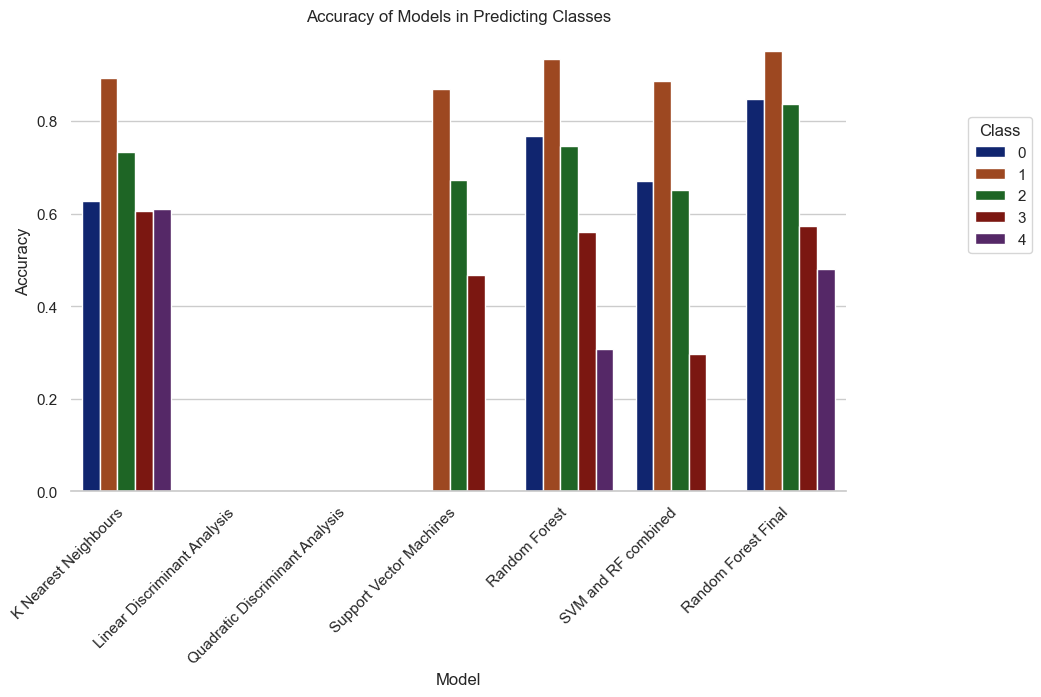

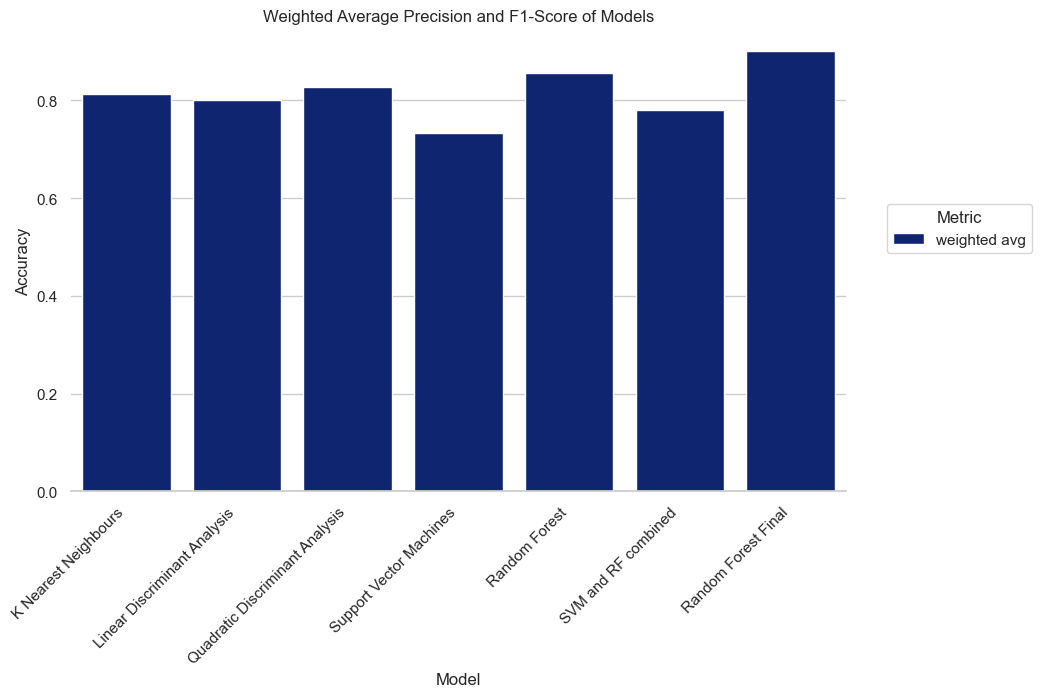

In [26]:
from sklearn.metrics import classification_report
import pandas as pd
import io
import seaborn as sns
import matplotlib.pyplot as plt

# Define the models and their respective reports
models = [('K Nearest Neighbours', knnresult),('Linear Discriminant Analysis', ldaresult), 
          ('Quadratic Discriminant Analysis', qdaresult), 
          ('Support Vector Machines', svm), 
          ('Random Forest', randomforest),
          ('SVM and RF combined', svmrf), 
          ('Random Forest Final', final)]

# Convert classification reports to dataframes
dfs = []
for name, report in models:
    try:
        df = pd.read_csv(io.StringIO(report), sep='\\s{2,}', engine='python').T
        df['model'] = name
        # Remove the 'support' row
        df = df[df.index != 'support']
        dfs.append(df)
    except:
        print(f"Error occurred while processing report for {name} model")

# Concatenate dataframes
df = pd.concat(dfs)

# Rename the class columns
df = df.rename(columns={'0.0': 'Class 0', '1.0': 'Class 1', '2.0': 'Class 2', '3.0': 'Class 3', '4.0': 'Class 4'})

# Separate the dataframes for the two graphs
class_df = df[['model', 'Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']].melt(id_vars=['model'], var_name='class', value_name='accuracy')
class_df['class'] = class_df['class'].str.replace('Class ', '').astype(int)
df = pd.melt(df.reset_index(), id_vars=['model'], var_name='variable', value_name='value')
weighted_df = df[df['variable'].isin(['weighted avg'])][['model', 'value', 'variable']]
weighted_df.columns = ['model', 'accuracy', 'metric']

# Define the models to plot
plot_models = ['K Nearest Neighbours', 'Linear Discriminant Analysis', 
               'Quadratic Discriminant Analysis', 
               'Support Vector Machines', 
               'Random Forest', 
               'SVM and RF combined', 
               'Random Forest Final']

# Plot the first graph
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x="model", y="accuracy", hue="class", data=class_df[class_df['model'].isin(plot_models)], palette=sns.color_palette("dark", n_colors=5), ci=None)
ax.set(title="Accuracy of Models in Predicting Classes")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
plt.legend(title='Class', loc='lower right', bbox_to_anchor=(1.25, 0.5))
sns.despine(left=True)
plt.show()

# Plot the second graph
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x="model", y="accuracy", hue="metric", data=weighted_df[weighted_df['model'].isin(plot_models)], palette=sns.color_palette("dark", n_colors=2), ci=None)
ax.set(title="Weighted Average Precision and F1-Score of Models")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
plt.legend(title='Metric', loc='lower right', bbox_to_anchor=(1.25, 0.5))
sns.despine(left=True)
plt.show()
